In [1]:
from src.nn.ansatz.default import default_circuit, custom_circuit
from src.nn.encodings.pennylane_templates import amplitude_embedding, angle_embedding
from src.nn.encodings.waterfall_embedding import waterfall_embedding
from src.nn.models.hybrid.HQNN_Parallel import HQNN_Parallel
%cd ..

import torch
import time
import numpy as np
import pennylane as qml

from src.nn.encodings import *
from src.nn.ansatz import *

from src.nn.encodings.IQP_embedding import custom_iqp_embedding

from src.nn.ansatz.no_entanglement_circuit import no_entanglement_random_circuit
from src.nn.ansatz.full_entanglement_circuit import full_entanglement_circuit
from src.nn.ansatz.NQ_circuit import NQ_circuit
from src.nn.ansatz.ring_circuit import ring_circuit

from src.nn.measurements.default import default_measurement

from src.utils.dataset import load_dataset
from src.utils.load_params import load_params
from src.nn.models.hybrid.HQNN_quanv import FlexHybridCNN
from src.utils.training import Trainer


import logging
logging.getLogger("pennylane").setLevel(logging.WARNING)
logging.getLogger('matplotlib').setLevel(logging.WARNING)
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='IPython')

/Users/uribagi/Documents/GitHub/QML-Satellite-Image-Classification/.venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/Users/uribagi/Documents/GitHub/QML-Satellite-Image-Classification


In [2]:
limit = 100
dataset_ = "EuroSAT"
image_size = 32
test_size = 0.2
output = 'np' # 'np' or 'dl'
batch_size = 16

if dataset_ == "EuroSAT":
    allowed_classes = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
elif dataset_ == "DeepSat4":
    allowed_classes = ['BarrenLand', 'Trees', 'Grassland', 'Other']
elif dataset_ == "DeepSat6":
    allowed_classes = ['BarrenLand', 'Trees', 'Grassland', 'Roads', 'Buildings' , 'WaterBodies']

config = {
    #'allowed_classes': ['Forest', 'Highway', 'Pasture', 'SeaLake']
    #'allowed_classes': ['AnnualCrop', 'Forest', 'Highway', 'Pasture', 'River', 'SeaLake']
}

allowed_classes = config.get('allowed_classes', allowed_classes)
train_loader, val_loader = load_dataset(dataset_, output, limit, allowed_classes, image_size, test_size, batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(f"Using device: {device}")
torch.backends.cudnn.benchmark = True


Class distribution in train set:
Class 0: 80
Class 1: 80
Class 2: 80
Class 3: 80
Class 4: 80
Class 5: 80
Class 6: 80
Class 7: 80
Class 8: 80
Class 9: 80

Class distribution in validation set:
Class 0: 20
Class 1: 20
Class 2: 20
Class 3: 20
Class 4: 20
Class 5: 20
Class 6: 20
Class 7: 20
Class 8: 20
Class 9: 20


# HQNN-Parallel

In [3]:
use_quantum, log_wandb, plot = False, False, True
n_classes = len(allowed_classes)
early_stopping, patience = True, 4

name_run = "HQNN_Parallel"
num_qubits_per_circuit = 8
learning_rate = 0.01
epochs = 10

print("Testing with the", dataset_, "dataset")

Testing with the EuroSAT dataset


In [4]:
amplitude_encoding_params = {
    "func":  amplitude_embedding,
    "func_params": {
        "normalize" : True,
        "pad_with": 0.0,
    }
}

angle_encoding_params = {
    "func": angle_embedding,
    "func_params": {
        "rotation" : "X"
    }
}

waterfall_encoding_params = {
    "func": waterfall_embedding,
    "func_params": {

    }
}

iqp_encoding_params = {
    "func": custom_iqp_embedding,
    "func_params": {
        "n_repeats": 2,
        "pattern": None
    }
}

num_layers = 2
weights_strongly_entangled = (2 * torch.rand(num_layers, num_qubits_per_circuit, 3) - 1) * np.pi
weights_random = (2 * torch.rand(num_layers, num_qubits_per_circuit, 3) - 1) * np.pi

default_circuit_params = {
    "func": default_circuit,
    "func_params": {
        "num_layers": num_layers,
        "weights": weights_random,
        "weight_shapes": {"weights": (num_layers, num_qubits_per_circuit)},
    }
}

strongly_entangled_circuit_params = {
    "func": custom_circuit,
    "func_params": {
        "num_layers": num_layers,
        "weights": weights_strongly_entangled,
        "weight_shapes": {"weights": (num_layers, num_qubits_per_circuit, 3)},
    }
}

measurement_params = {
    "func": default_measurement,
    "func_params": {
        "observable": qml.PauliX,
        "measured_qubits": range(num_qubits_per_circuit),
    }
}

In [5]:
model = HQNN_Parallel(iqp_encoding_params, strongly_entangled_circuit_params, measurement_params, use_quantum=False)

In [6]:
trainer = Trainer(model = model,
                  train_loader = train_loader,
                  val_loader = val_loader,
                  epochs = epochs,
                  early_stopping = early_stopping,
                  patience = patience,
                  log_wandb = log_wandb,
                  wandb_project = "test",
                  wandb_run_name = name_run,
                  use_quantum = use_quantum,
                  plot = plot,
                  allowed_classes = allowed_classes,
                  lr = learning_rate,
                  use_schedulefree=True
                 )

Epoch [1/10]: Train Loss = 2.1216, Train Acc = 15.25%, Val Loss = 1.9380, Val Acc = 28.00%
Epoch [2/10]: Train Loss = 1.9274, Train Acc = 25.38%, Val Loss = 1.8506, Val Acc = 26.50%
Epoch [3/10]: Train Loss = 1.8306, Train Acc = 28.25%, Val Loss = 1.8066, Val Acc = 33.50%
Epoch [4/10]: Train Loss = 1.6511, Train Acc = 37.12%, Val Loss = 1.7052, Val Acc = 39.00%
Epoch [5/10]: Train Loss = 1.5073, Train Acc = 43.38%, Val Loss = 1.5987, Val Acc = 44.00%
Epoch [6/10]: Train Loss = 1.3927, Train Acc = 45.50%, Val Loss = 1.5218, Val Acc = 42.50%
Epoch [7/10]: Train Loss = 1.2725, Train Acc = 52.50%, Val Loss = 1.4554, Val Acc = 47.00%
Epoch [8/10]: Train Loss = 1.2316, Train Acc = 54.25%, Val Loss = 1.4742, Val Acc = 45.50%
Epoch [9/10]: Train Loss = 1.0979, Train Acc = 57.25%, Val Loss = 1.4597, Val Acc = 49.00%
Epoch [10/10]: Train Loss = 0.9145, Train Acc = 65.88%, Val Loss = 1.4624, Val Acc = 49.50%


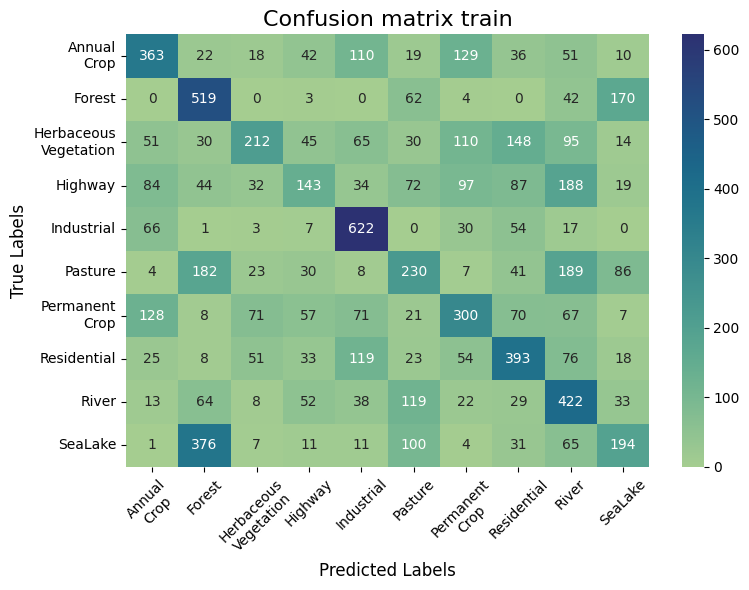

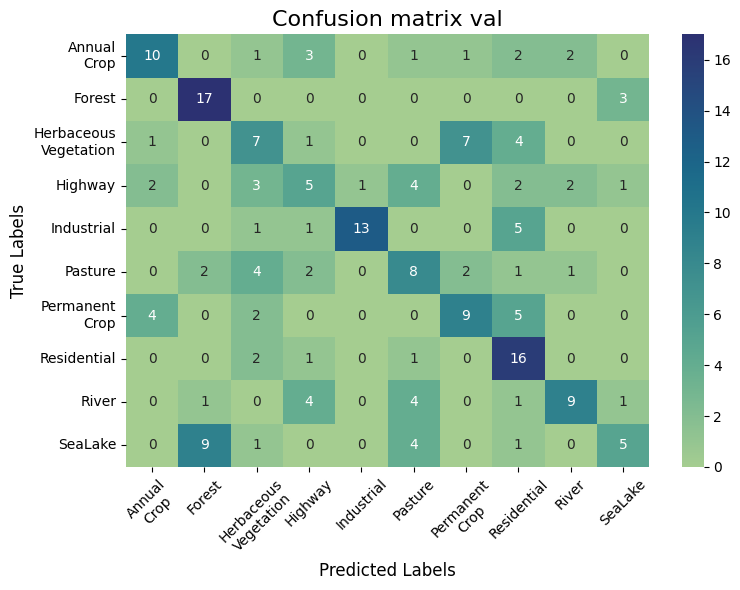

In [7]:
trainer.fit()

In [8]:
model = HQNN_Parallel(angle_encoding_params, strongly_entangled_circuit_params, measurement_params, use_quantum=True)


In [9]:
trainer = Trainer(model = model,
                  train_loader = train_loader,
                  val_loader = val_loader,
                  epochs = epochs,
                  early_stopping = early_stopping,
                  patience = patience,
                  log_wandb = log_wandb,
                  wandb_project = "test",
                  wandb_run_name = name_run,
                  use_quantum = use_quantum,
                  plot = plot,
                  allowed_classes = allowed_classes,
                  lr = learning_rate,
                  use_schedulefree=True
                 )

Epoch [1/10]: Train Loss = 2.1436, Train Acc = 17.12%, Val Loss = 1.9330, Val Acc = 24.00%
Epoch [2/10]: Train Loss = 1.8433, Train Acc = 26.38%, Val Loss = 1.7252, Val Acc = 32.50%
Epoch [3/10]: Train Loss = 1.6404, Train Acc = 34.75%, Val Loss = 1.6300, Val Acc = 39.50%
Epoch [4/10]: Train Loss = 1.4841, Train Acc = 40.62%, Val Loss = 1.5858, Val Acc = 37.00%
Epoch [5/10]: Train Loss = 1.2890, Train Acc = 49.00%, Val Loss = 1.6361, Val Acc = 42.00%
Epoch [6/10]: Train Loss = 1.1155, Train Acc = 57.00%, Val Loss = 1.6727, Val Acc = 42.00%
Epoch [7/10]: Train Loss = 0.9327, Train Acc = 63.38%, Val Loss = 1.8015, Val Acc = 41.50%
Early stopping at epoch 8


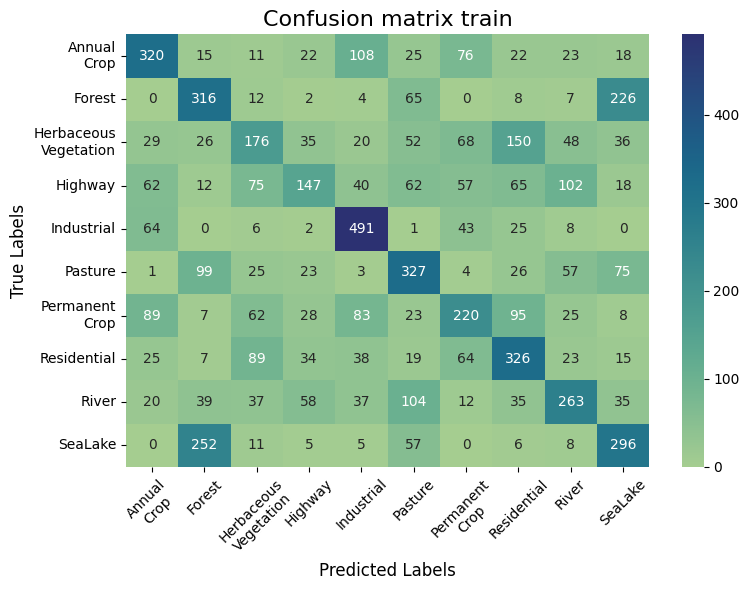

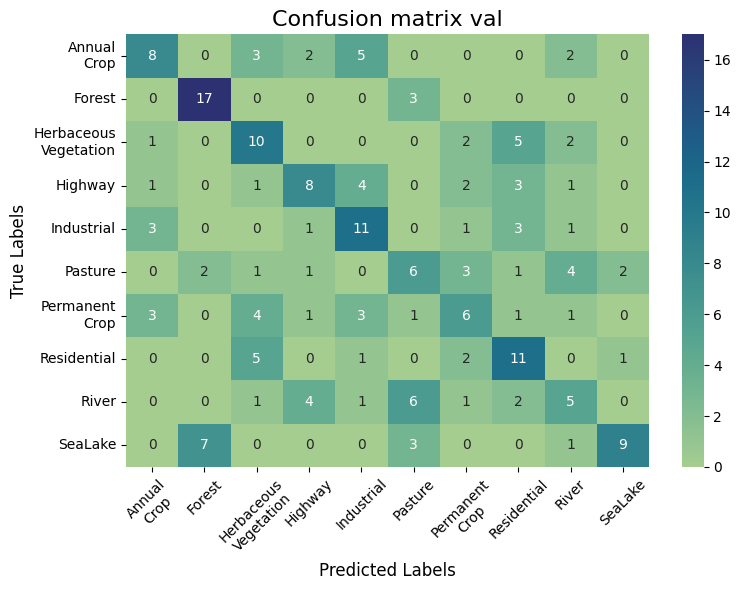

In [10]:
trainer.fit()